# LightGlue 
In this notebook we match two pairs of images using LightGlue with early stopping and point pruning.

In [1]:
# If we are on colab: this clones the repo and installs the dependencies
from pathlib import Path
if Path.cwd().name != 'LightGlue':
  !git clone --quiet https://github.com/cvg/LightGlue/
  %cd LightGlue
  %pip install --progress-bar off --quiet -e .
    
from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch
torch.set_grad_enabled(False);
images = Path('assets')

## Extractor and matcher module


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 'mps', 'cpu'

extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features='superpoint').eval().to(device)

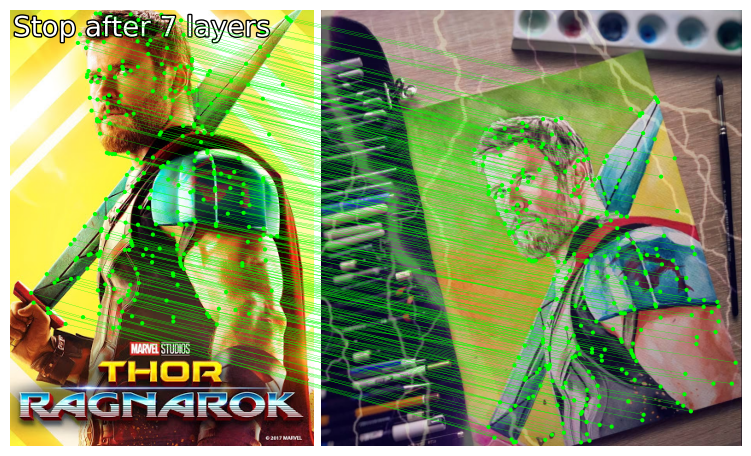

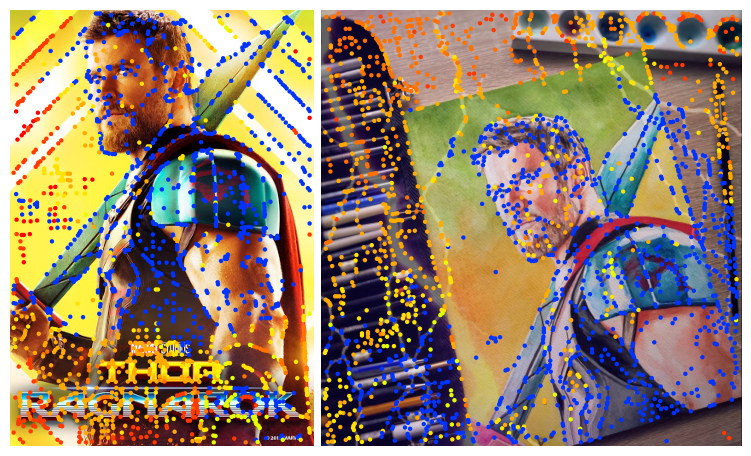

In [3]:
image0 = load_image(images / 'Obraz.jpg')
image1 = load_image(images / 'Rysunek.jpg')

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({'image0': feats0, 'image1': feats1})
feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]  # remove batch dimension

kpts0, kpts1, matches = feats0['keypoints'], feats1['keypoints'], matches01['matches']
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color='lime', lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

kpc0, kpc1 = viz2d.cm_prune(matches01['prune0']), viz2d.cm_prune(matches01['prune1'])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)